### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 126 elements
My custom valing-dataset has 42 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

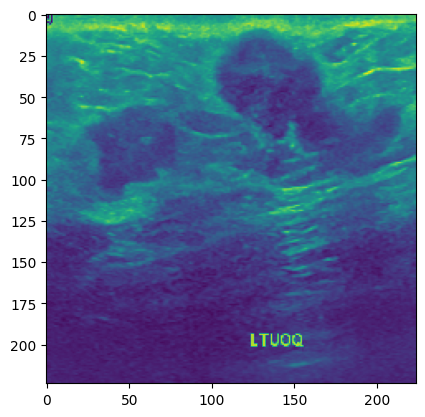

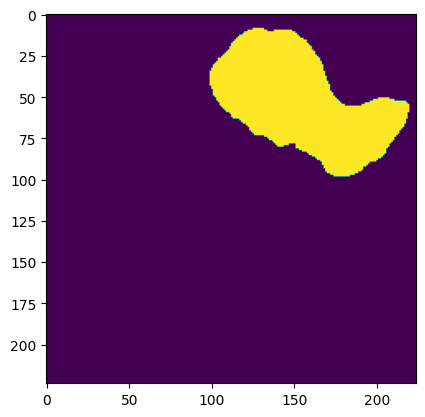

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p
model = DeepLab_V3_p(backbone = 'resnet', num_classes = 1)   # backbone : 선택 (resnet, xception, mobilenet)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'DeepLab_V3+'
data_name = 'malignant'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 16 of 16, Train Loss: 1.201219, IoU: 0.277779, Dice: 0.406893
 Epoch: 1 of 100, Iter.: 16 of 16, Valid Loss: 1.404959, IoU: 0.256881, Dice: 0.387193

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


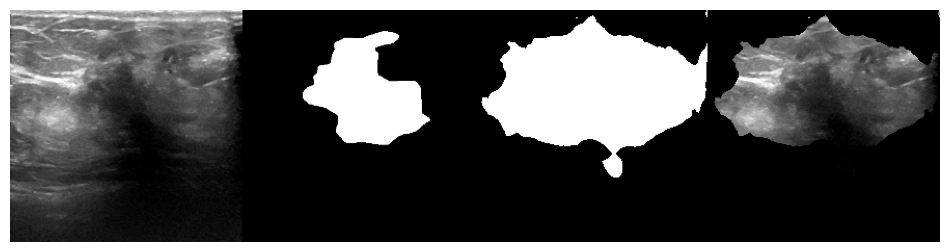

 Epoch: 2 of 100, Iter.: 16 of 16, Train Loss: 0.927632, IoU: 0.434567, Dice: 0.576768
 Epoch: 2 of 100, Iter.: 16 of 16, Valid Loss: 1.330223, IoU: 0.327939, Dice: 0.468711


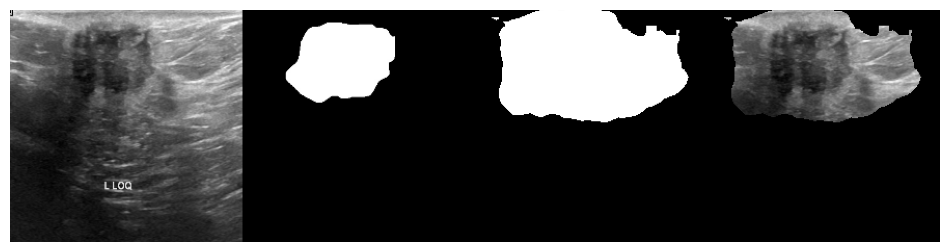

 Epoch: 3 of 100, Iter.: 16 of 16, Train Loss: 0.604226, IoU: 0.597418, Dice: 0.720934
 Epoch: 3 of 100, Iter.: 16 of 16, Valid Loss: 1.495855, IoU: 0.441153, Dice: 0.581172


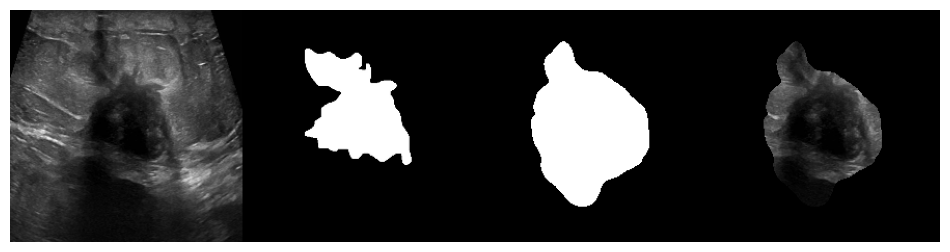

 Epoch: 4 of 100, Iter.: 16 of 16, Train Loss: 0.447877, IoU: 0.662643, Dice: 0.775044
 Epoch: 4 of 100, Iter.: 16 of 16, Valid Loss: 0.978280, IoU: 0.474084, Dice: 0.617427


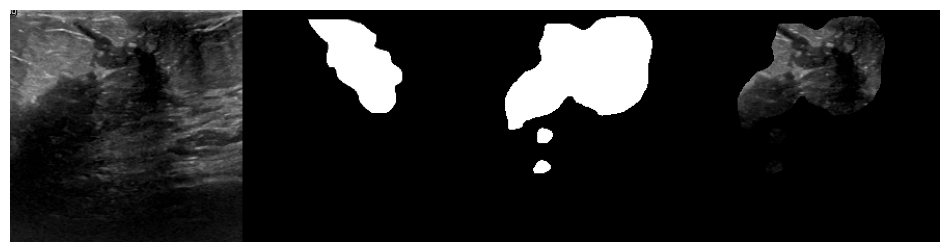

 Epoch: 5 of 100, Iter.: 16 of 16, Train Loss: 0.367323, IoU: 0.696452, Dice: 0.799430
 Epoch: 5 of 100, Iter.: 16 of 16, Valid Loss: 0.669177, IoU: 0.537019, Dice: 0.670706


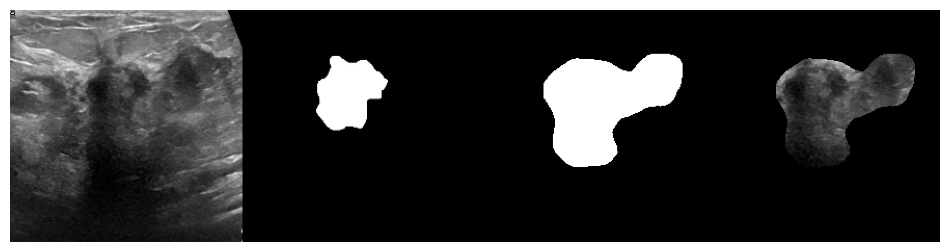

 Epoch: 6 of 100, Iter.: 16 of 16, Train Loss: 0.290058, IoU: 0.741687, Dice: 0.834601
 Epoch: 6 of 100, Iter.: 16 of 16, Valid Loss: 0.646345, IoU: 0.528115, Dice: 0.663586


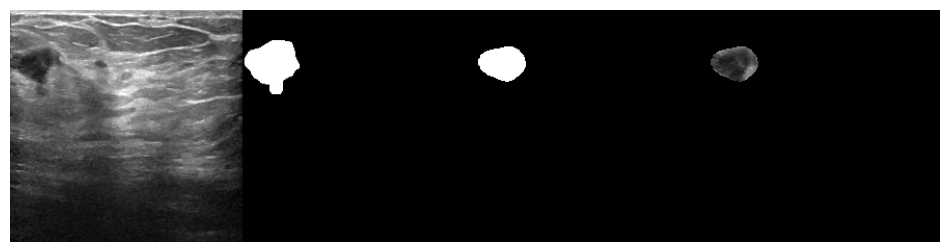

 Epoch: 7 of 100, Iter.: 16 of 16, Train Loss: 0.245257, IoU: 0.787697, Dice: 0.871937
 Epoch: 7 of 100, Iter.: 16 of 16, Valid Loss: 0.648154, IoU: 0.548682, Dice: 0.675312


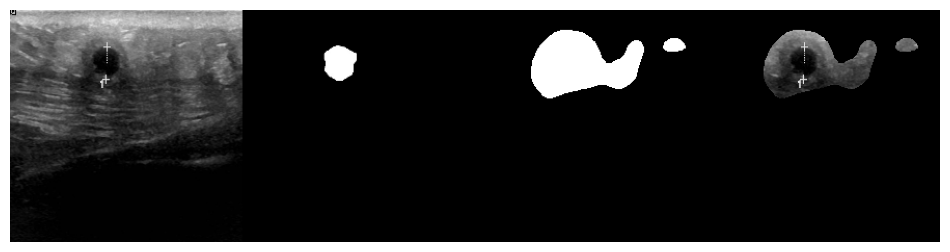

 Epoch: 8 of 100, Iter.: 16 of 16, Train Loss: 0.211050, IoU: 0.801816, Dice: 0.877461
 Epoch: 8 of 100, Iter.: 16 of 16, Valid Loss: 0.575118, IoU: 0.532258, Dice: 0.655035


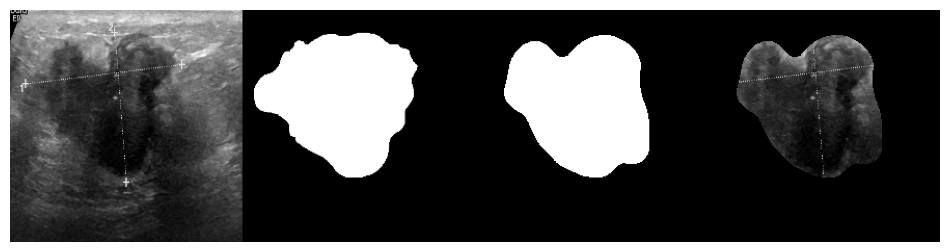

 Epoch: 9 of 100, Iter.: 16 of 16, Train Loss: 0.189232, IoU: 0.834337, Dice: 0.906426
 Epoch: 9 of 100, Iter.: 16 of 16, Valid Loss: 0.588958, IoU: 0.569316, Dice: 0.699020


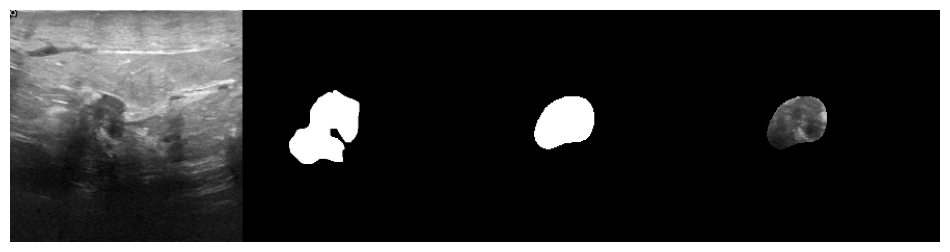

 Epoch: 10 of 100, Iter.: 16 of 16, Train Loss: 0.182034, IoU: 0.832834, Dice: 0.902767
 Epoch: 10 of 100, Iter.: 16 of 16, Valid Loss: 0.553421, IoU: 0.564550, Dice: 0.692029


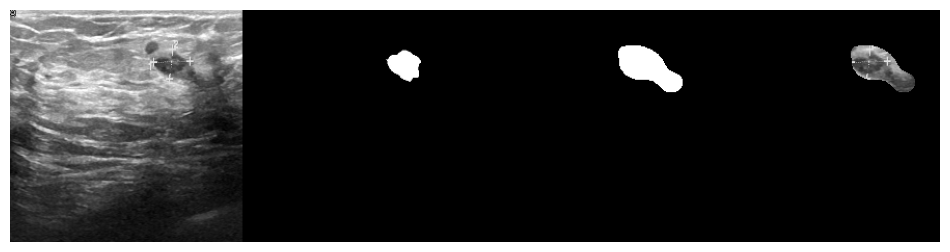

 Epoch: 11 of 100, Iter.: 16 of 16, Train Loss: 0.186094, IoU: 0.828860, Dice: 0.900676
 Epoch: 11 of 100, Iter.: 16 of 16, Valid Loss: 0.620164, IoU: 0.563967, Dice: 0.694038


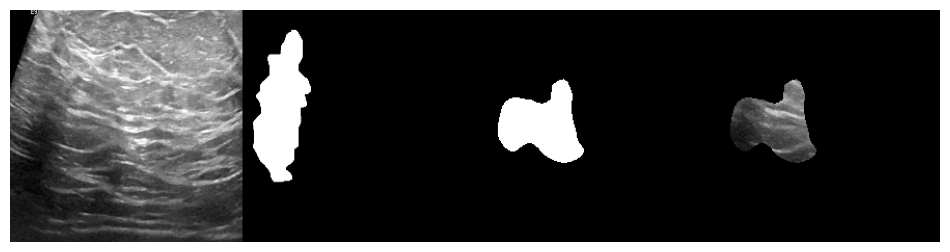

 Epoch: 12 of 100, Iter.: 16 of 16, Train Loss: 0.159999, IoU: 0.843503, Dice: 0.907120
 Epoch: 12 of 100, Iter.: 16 of 16, Valid Loss: 0.589162, IoU: 0.524955, Dice: 0.654036


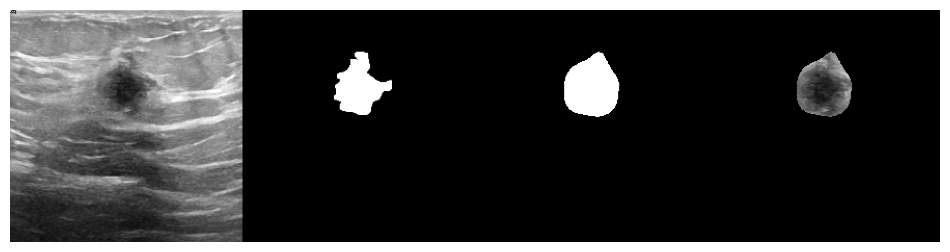

 Epoch: 13 of 100, Iter.: 16 of 16, Train Loss: 0.157006, IoU: 0.851781, Dice: 0.918008
 Epoch: 13 of 100, Iter.: 16 of 16, Valid Loss: 0.641024, IoU: 0.561761, Dice: 0.689652


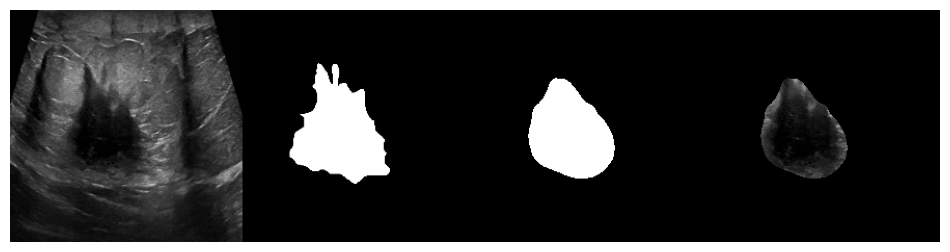

 Epoch: 14 of 100, Iter.: 16 of 16, Train Loss: 0.146445, IoU: 0.855317, Dice: 0.920091
 Epoch: 14 of 100, Iter.: 16 of 16, Valid Loss: 0.552743, IoU: 0.566255, Dice: 0.693070


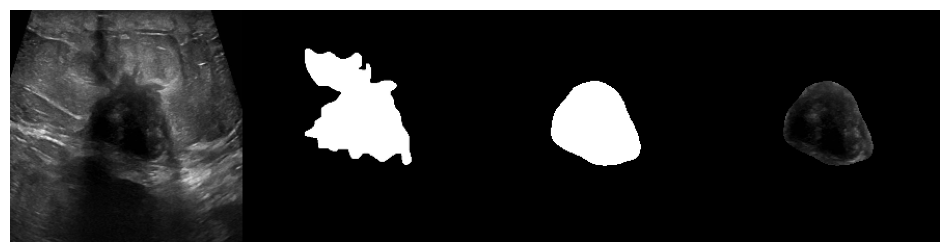

 Epoch: 15 of 100, Iter.: 16 of 16, Train Loss: 0.128947, IoU: 0.870346, Dice: 0.928670
 Epoch: 15 of 100, Iter.: 16 of 16, Valid Loss: 0.577263, IoU: 0.554694, Dice: 0.684494


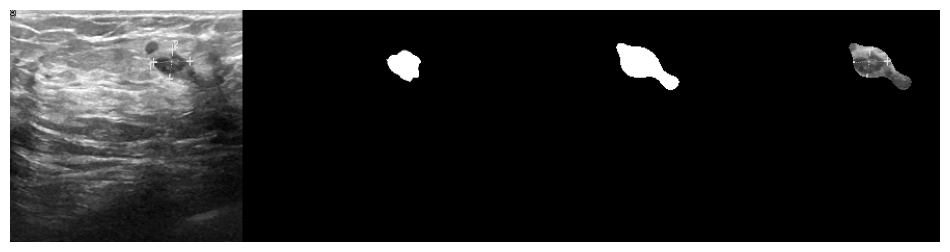

 Epoch: 16 of 100, Iter.: 16 of 16, Train Loss: 0.119850, IoU: 0.872315, Dice: 0.927136
 Epoch: 16 of 100, Iter.: 16 of 16, Valid Loss: 0.581957, IoU: 0.550480, Dice: 0.676993


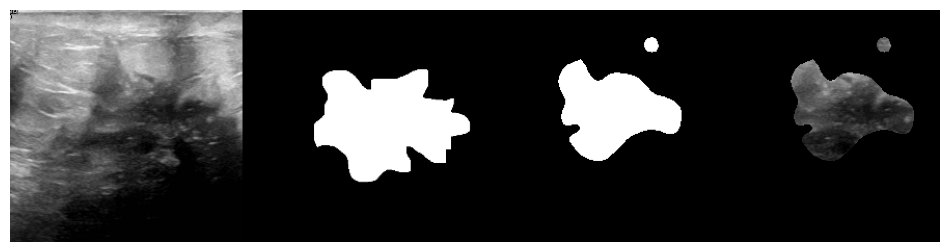

 Epoch: 17 of 100, Iter.: 16 of 16, Train Loss: 0.120142, IoU: 0.880600, Dice: 0.935098
 Epoch: 17 of 100, Iter.: 16 of 16, Valid Loss: 0.582587, IoU: 0.559366, Dice: 0.686881


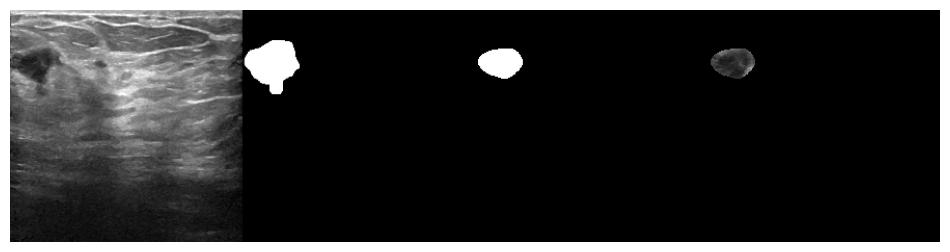

 Epoch: 18 of 100, Iter.: 16 of 16, Train Loss: 0.106493, IoU: 0.885777, Dice: 0.938213
 Epoch: 18 of 100, Iter.: 16 of 16, Valid Loss: 0.582706, IoU: 0.554544, Dice: 0.684466


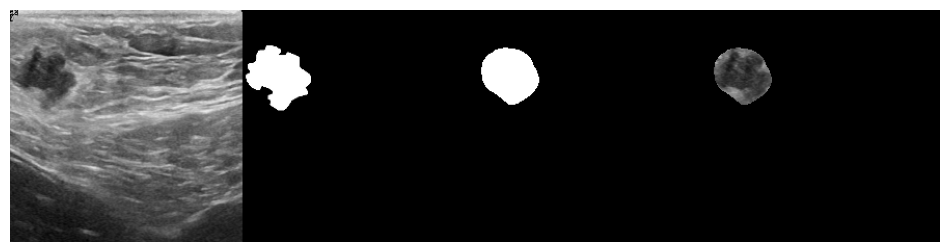

 Epoch: 19 of 100, Iter.: 16 of 16, Train Loss: 0.112903, IoU: 0.883195, Dice: 0.936384
 Epoch: 19 of 100, Iter.: 16 of 16, Valid Loss: 0.609366, IoU: 0.533886, Dice: 0.661945


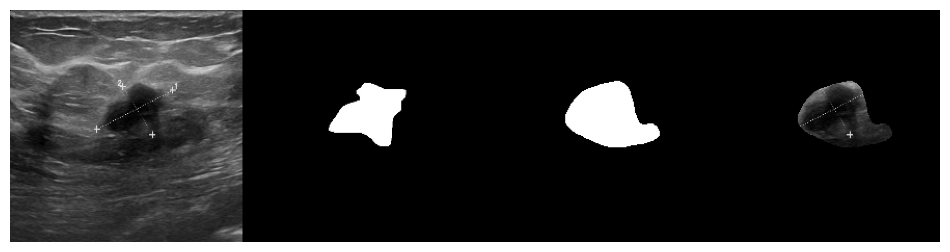

 Epoch: 20 of 100, Iter.: 16 of 16, Train Loss: 0.107082, IoU: 0.887572, Dice: 0.936355
 Epoch: 20 of 100, Iter.: 16 of 16, Valid Loss: 0.578246, IoU: 0.575219, Dice: 0.702386


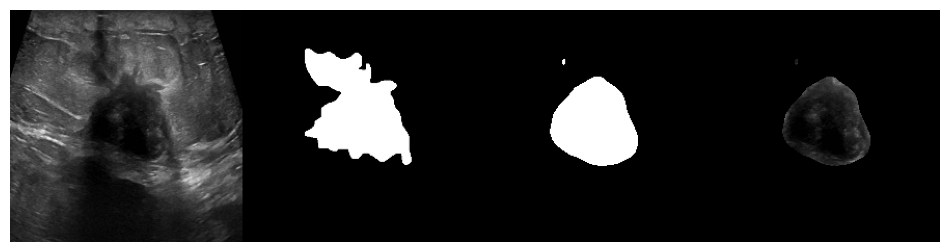

 Epoch: 21 of 100, Iter.: 16 of 16, Train Loss: 0.100788, IoU: 0.888129, Dice: 0.938483
 Epoch: 21 of 100, Iter.: 16 of 16, Valid Loss: 0.589456, IoU: 0.546838, Dice: 0.677025


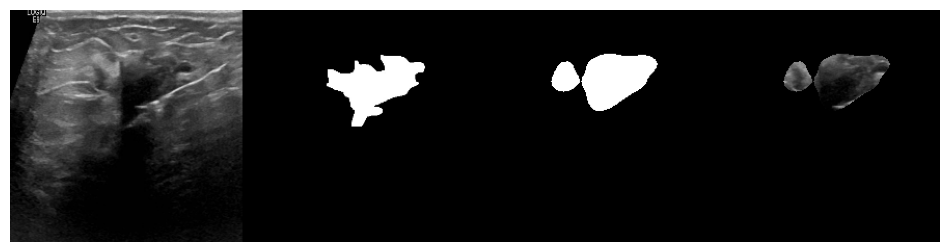

 Epoch: 22 of 100, Iter.: 16 of 16, Train Loss: 0.098626, IoU: 0.898272, Dice: 0.945661
 Epoch: 22 of 100, Iter.: 16 of 16, Valid Loss: 0.619651, IoU: 0.545848, Dice: 0.677084


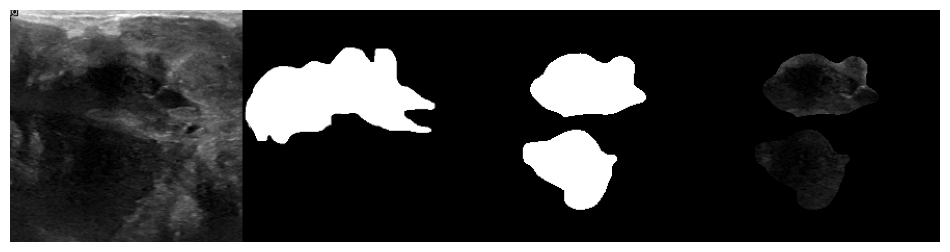

 Epoch: 23 of 100, Iter.: 16 of 16, Train Loss: 0.097423, IoU: 0.896656, Dice: 0.944713
 Epoch: 23 of 100, Iter.: 16 of 16, Valid Loss: 0.603145, IoU: 0.548933, Dice: 0.679222


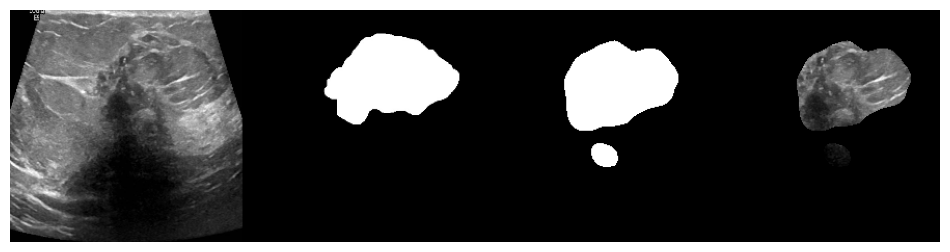

 Epoch: 24 of 100, Iter.: 16 of 16, Train Loss: 0.091666, IoU: 0.899825, Dice: 0.946530
 Epoch: 24 of 100, Iter.: 16 of 16, Valid Loss: 0.583203, IoU: 0.570322, Dice: 0.694430


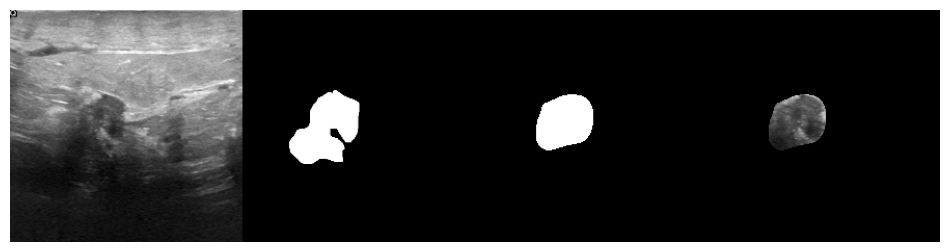

 Epoch: 25 of 100, Iter.: 16 of 16, Train Loss: 0.089680, IoU: 0.902696, Dice: 0.947975
 Epoch: 25 of 100, Iter.: 16 of 16, Valid Loss: 0.580634, IoU: 0.569372, Dice: 0.696098


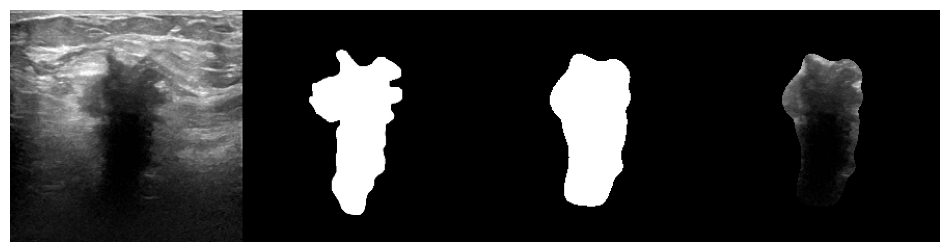

 Epoch: 26 of 100, Iter.: 16 of 16, Train Loss: 0.085266, IoU: 0.905888, Dice: 0.950027
 Epoch: 26 of 100, Iter.: 16 of 16, Valid Loss: 0.566527, IoU: 0.578923, Dice: 0.702814


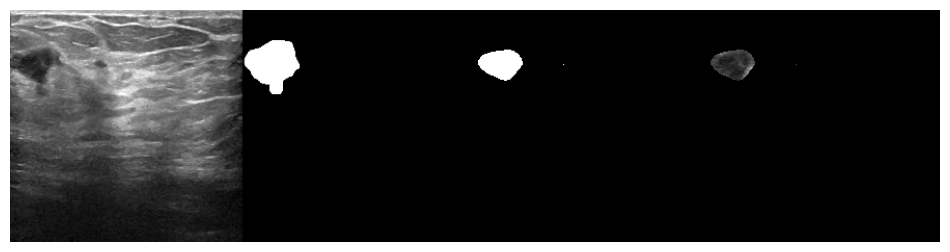

 Epoch: 27 of 100, Iter.: 16 of 16, Train Loss: 0.083768, IoU: 0.904926, Dice: 0.947559
 Epoch: 27 of 100, Iter.: 16 of 16, Valid Loss: 0.583168, IoU: 0.574194, Dice: 0.699646


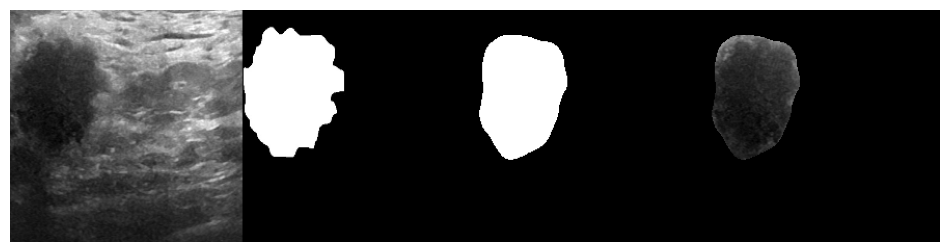

 Epoch: 28 of 100, Iter.: 16 of 16, Train Loss: 0.080774, IoU: 0.908290, Dice: 0.951171
 Epoch: 28 of 100, Iter.: 16 of 16, Valid Loss: 0.570019, IoU: 0.573808, Dice: 0.696350


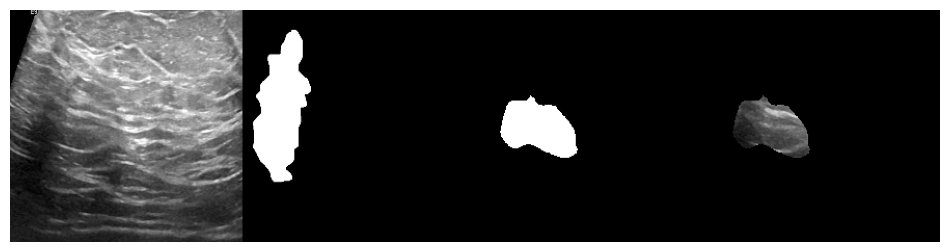

 Epoch: 29 of 100, Iter.: 16 of 16, Train Loss: 0.083823, IoU: 0.908304, Dice: 0.951227
 Epoch: 29 of 100, Iter.: 16 of 16, Valid Loss: 0.568444, IoU: 0.576976, Dice: 0.699088


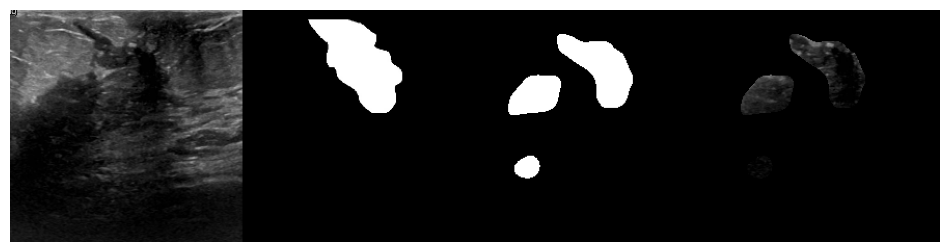

 Epoch: 30 of 100, Iter.: 16 of 16, Train Loss: 0.090084, IoU: 0.905811, Dice: 0.949843
 Epoch: 30 of 100, Iter.: 16 of 16, Valid Loss: 0.556861, IoU: 0.582298, Dice: 0.702089


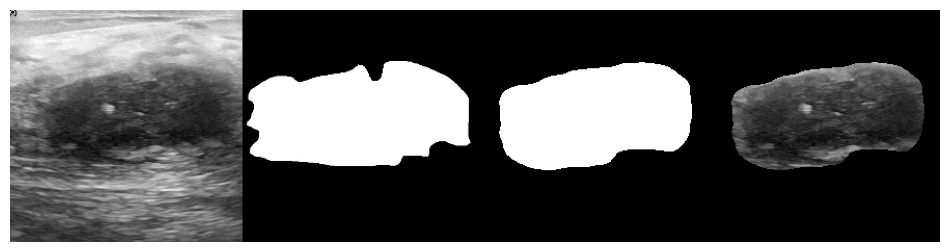

 Epoch: 31 of 100, Iter.: 16 of 16, Train Loss: 0.080489, IoU: 0.909902, Dice: 0.952164
 Epoch: 31 of 100, Iter.: 16 of 16, Valid Loss: 0.577377, IoU: 0.578134, Dice: 0.702558


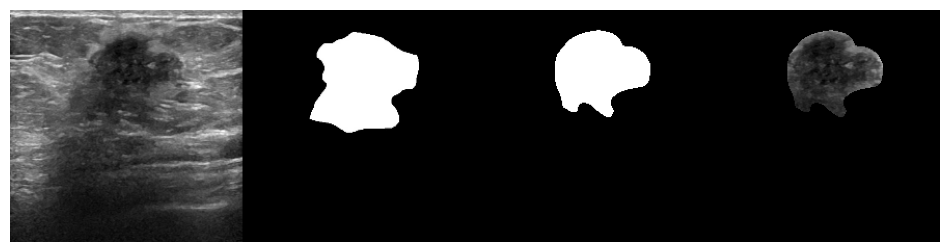

 Epoch: 32 of 100, Iter.: 16 of 16, Train Loss: 0.078111, IoU: 0.911271, Dice: 0.952713
 Epoch: 32 of 100, Iter.: 16 of 16, Valid Loss: 0.554998, IoU: 0.583177, Dice: 0.707846


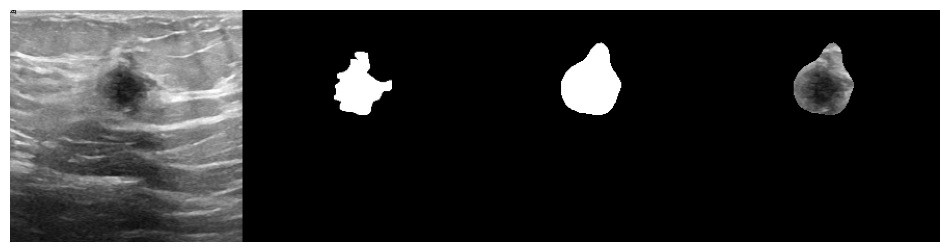

 Epoch: 33 of 100, Iter.: 16 of 16, Train Loss: 0.078068, IoU: 0.910807, Dice: 0.952708
 Epoch: 33 of 100, Iter.: 16 of 16, Valid Loss: 0.561397, IoU: 0.583952, Dice: 0.707690


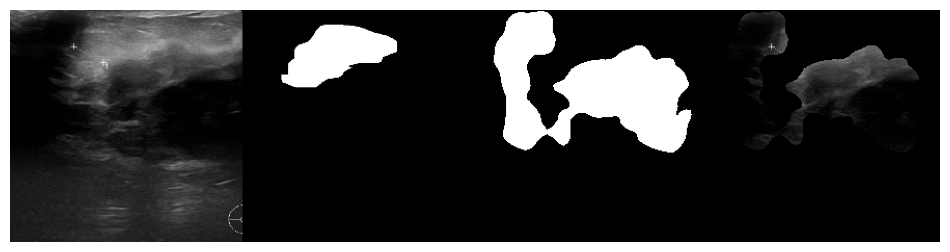

 Epoch: 34 of 100, Iter.: 16 of 16, Train Loss: 0.078831, IoU: 0.913689, Dice: 0.954325
 Epoch: 34 of 100, Iter.: 16 of 16, Valid Loss: 0.563422, IoU: 0.583998, Dice: 0.707378


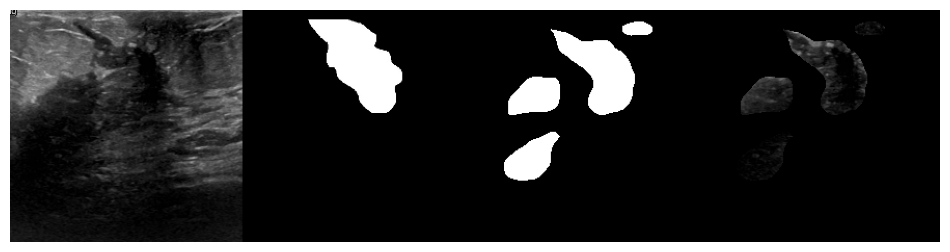

 Epoch: 35 of 100, Iter.: 16 of 16, Train Loss: 0.073177, IoU: 0.912429, Dice: 0.953349
 Epoch: 35 of 100, Iter.: 16 of 16, Valid Loss: 0.578662, IoU: 0.582795, Dice: 0.706176


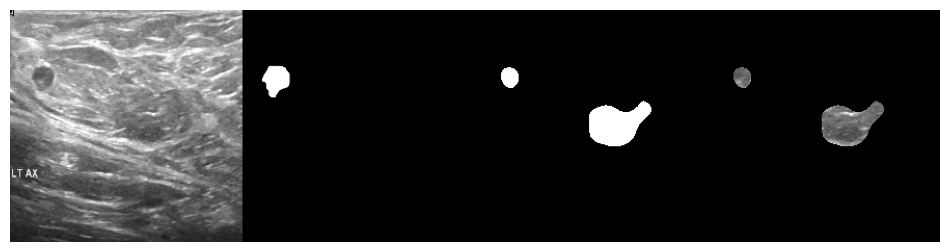

 Epoch: 36 of 100, Iter.: 16 of 16, Train Loss: 0.070074, IoU: 0.919001, Dice: 0.957314
 Epoch: 36 of 100, Iter.: 16 of 16, Valid Loss: 0.565604, IoU: 0.585763, Dice: 0.707645


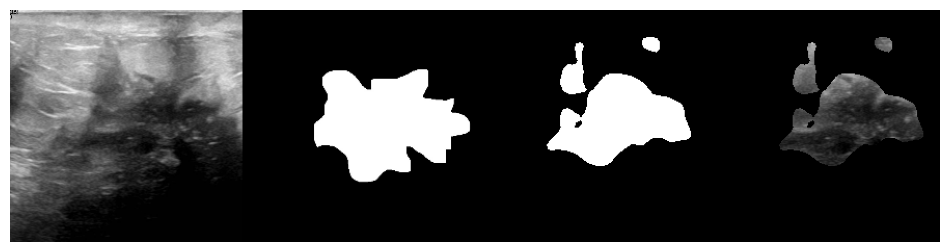

 Epoch: 37 of 100, Iter.: 16 of 16, Train Loss: 0.076000, IoU: 0.915308, Dice: 0.954985
 Epoch: 37 of 100, Iter.: 16 of 16, Valid Loss: 0.575016, IoU: 0.588639, Dice: 0.710497


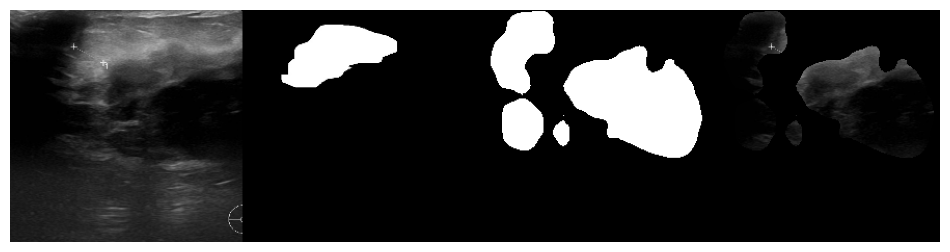

 Epoch: 38 of 100, Iter.: 16 of 16, Train Loss: 0.078209, IoU: 0.909605, Dice: 0.951380
 Epoch: 38 of 100, Iter.: 16 of 16, Valid Loss: 0.549664, IoU: 0.592180, Dice: 0.713098


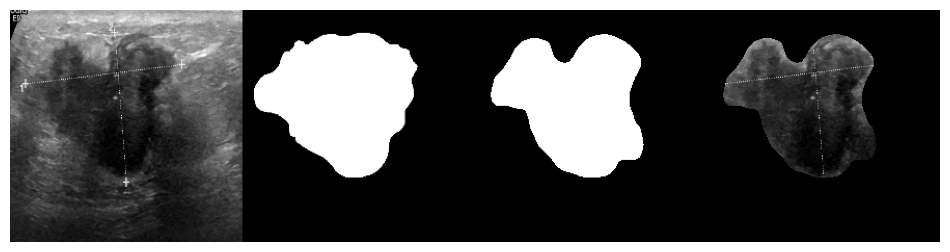

 Epoch: 39 of 100, Iter.: 16 of 16, Train Loss: 0.075569, IoU: 0.911396, Dice: 0.952136
 Epoch: 39 of 100, Iter.: 16 of 16, Valid Loss: 0.578197, IoU: 0.580930, Dice: 0.706332


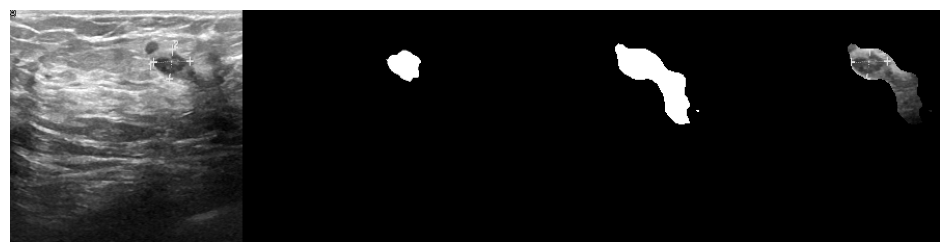

 Epoch: 40 of 100, Iter.: 16 of 16, Train Loss: 0.070090, IoU: 0.918267, Dice: 0.956746
 Epoch: 40 of 100, Iter.: 16 of 16, Valid Loss: 0.631416, IoU: 0.546004, Dice: 0.670038


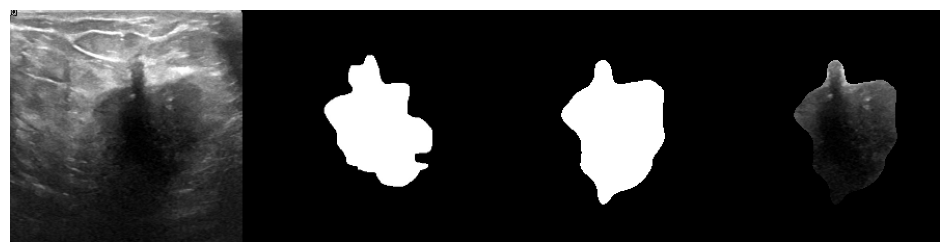

 Epoch: 41 of 100, Iter.: 16 of 16, Train Loss: 0.069689, IoU: 0.918467, Dice: 0.956977
 Epoch: 41 of 100, Iter.: 16 of 16, Valid Loss: 0.596290, IoU: 0.583758, Dice: 0.705006


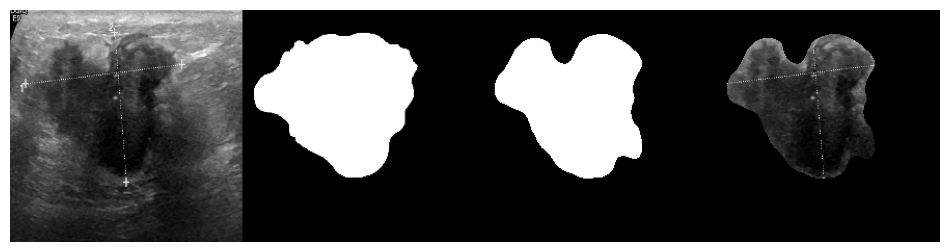

 Epoch: 42 of 100, Iter.: 16 of 16, Train Loss: 0.066365, IoU: 0.923168, Dice: 0.959660
 Epoch: 42 of 100, Iter.: 16 of 16, Valid Loss: 0.599875, IoU: 0.570902, Dice: 0.692856


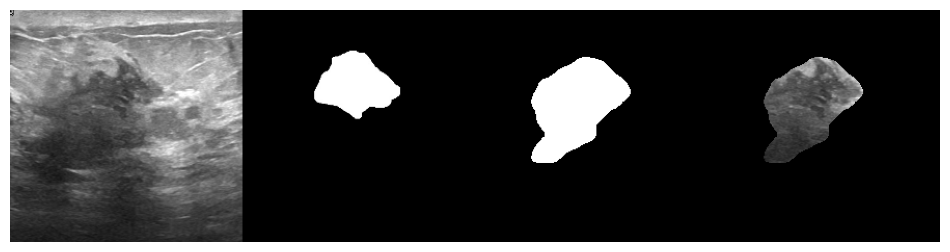

 Epoch: 43 of 100, Iter.: 16 of 16, Train Loss: 0.063674, IoU: 0.925934, Dice: 0.961183
 Epoch: 43 of 100, Iter.: 16 of 16, Valid Loss: 0.577032, IoU: 0.579141, Dice: 0.701665


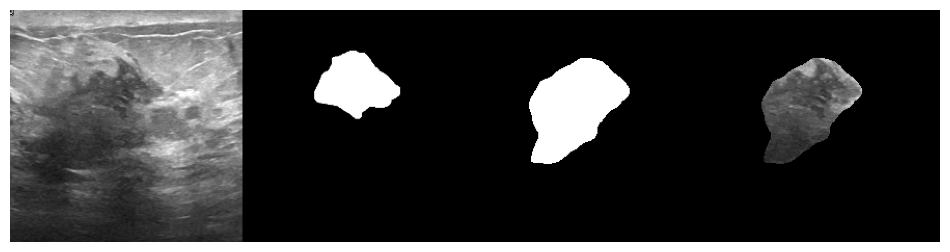

 Epoch: 44 of 100, Iter.: 16 of 16, Train Loss: 0.064366, IoU: 0.924797, Dice: 0.960499
 Epoch: 44 of 100, Iter.: 16 of 16, Valid Loss: 0.579786, IoU: 0.576958, Dice: 0.700881


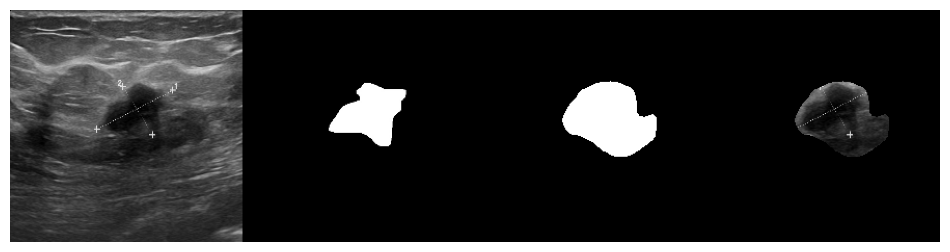

 Epoch: 45 of 100, Iter.: 16 of 16, Train Loss: 0.063697, IoU: 0.924428, Dice: 0.960241
 Epoch: 45 of 100, Iter.: 16 of 16, Valid Loss: 0.596975, IoU: 0.577803, Dice: 0.700429


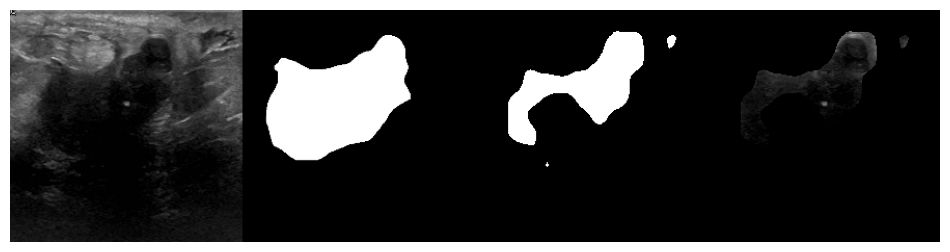

 Epoch: 46 of 100, Iter.: 16 of 16, Train Loss: 0.064368, IoU: 0.925795, Dice: 0.961047
 Epoch: 46 of 100, Iter.: 16 of 16, Valid Loss: 0.592454, IoU: 0.575943, Dice: 0.702042


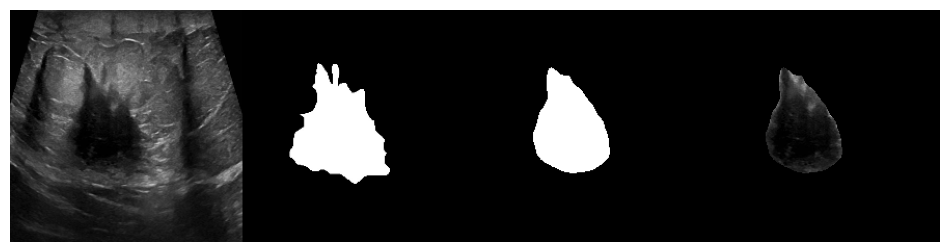

 Epoch: 47 of 100, Iter.: 16 of 16, Train Loss: 0.067108, IoU: 0.924709, Dice: 0.960501
 Epoch: 47 of 100, Iter.: 16 of 16, Valid Loss: 0.581147, IoU: 0.582226, Dice: 0.704407


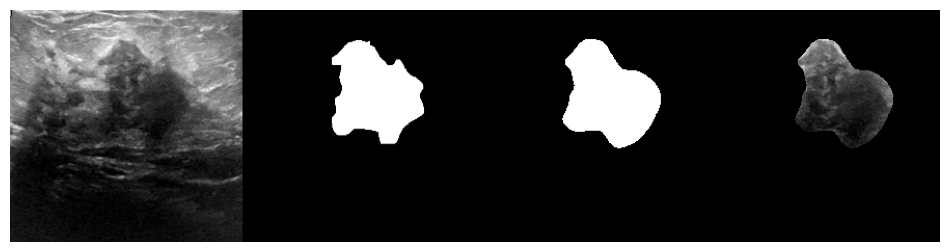

 Epoch: 48 of 100, Iter.: 16 of 16, Train Loss: 0.061371, IoU: 0.926964, Dice: 0.961617
 Epoch: 48 of 100, Iter.: 16 of 16, Valid Loss: 0.593768, IoU: 0.579893, Dice: 0.703366


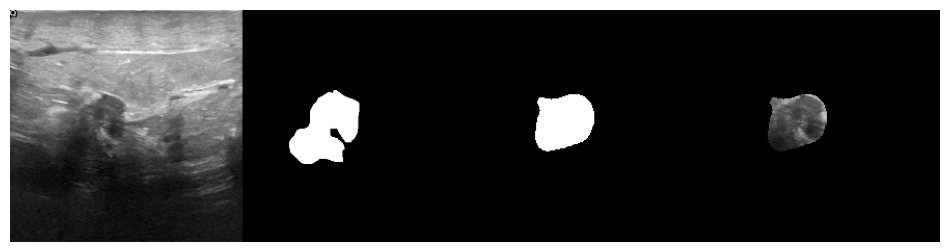

 Epoch: 49 of 100, Iter.: 16 of 16, Train Loss: 0.061424, IoU: 0.926265, Dice: 0.961240
 Epoch: 49 of 100, Iter.: 16 of 16, Valid Loss: 0.604250, IoU: 0.572026, Dice: 0.695107


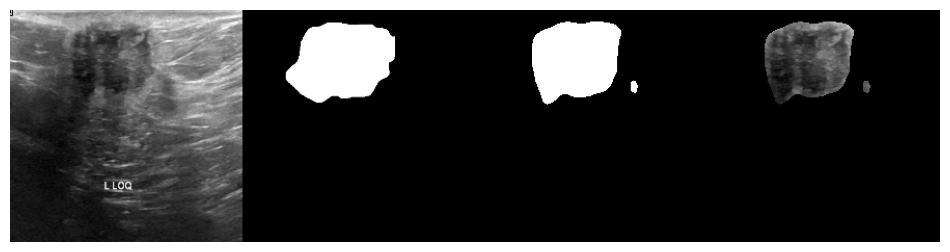

 Epoch: 50 of 100, Iter.: 16 of 16, Train Loss: 0.059888, IoU: 0.926856, Dice: 0.961465
 Epoch: 50 of 100, Iter.: 16 of 16, Valid Loss: 0.595175, IoU: 0.580223, Dice: 0.702746


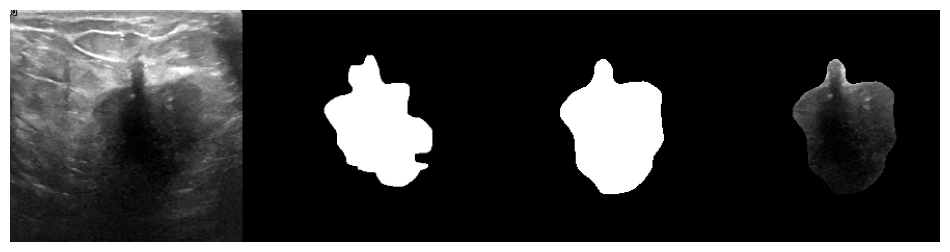

 Epoch: 51 of 100, Iter.: 16 of 16, Train Loss: 0.061068, IoU: 0.928464, Dice: 0.962512
 Epoch: 51 of 100, Iter.: 16 of 16, Valid Loss: 0.596731, IoU: 0.577144, Dice: 0.694387


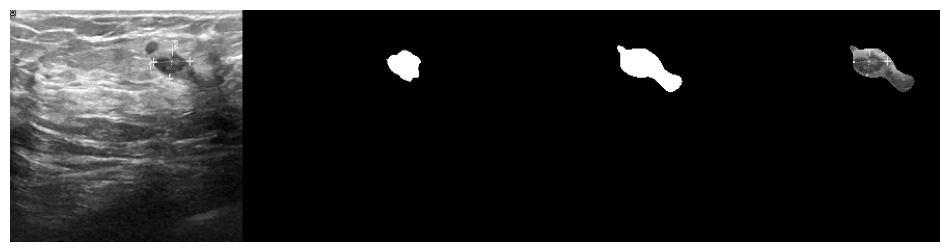

 Epoch: 52 of 100, Iter.: 16 of 16, Train Loss: 0.065423, IoU: 0.923330, Dice: 0.959496
 Epoch: 52 of 100, Iter.: 16 of 16, Valid Loss: 0.688392, IoU: 0.547203, Dice: 0.661628


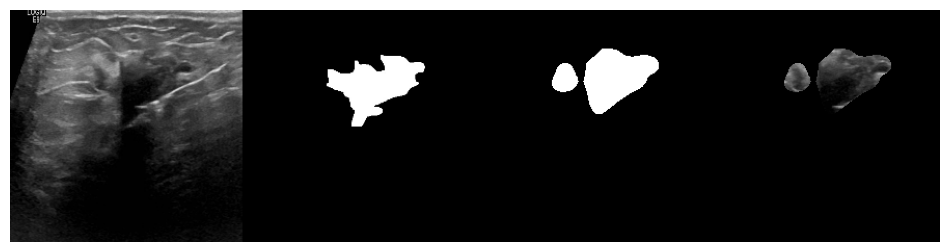

 Epoch: 53 of 100, Iter.: 16 of 16, Train Loss: 0.062653, IoU: 0.928322, Dice: 0.962523
 Epoch: 53 of 100, Iter.: 16 of 16, Valid Loss: 0.608578, IoU: 0.581150, Dice: 0.701126


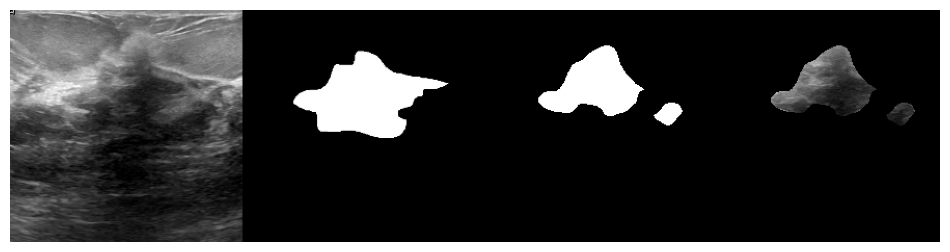

 Epoch: 54 of 100, Iter.: 16 of 16, Train Loss: 0.061587, IoU: 0.927481, Dice: 0.962001
 Epoch: 54 of 100, Iter.: 16 of 16, Valid Loss: 0.626658, IoU: 0.564239, Dice: 0.684792


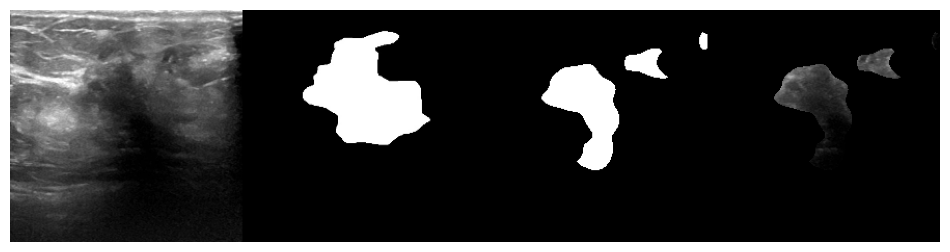

 Epoch: 55 of 100, Iter.: 16 of 16, Train Loss: 0.057113, IoU: 0.931025, Dice: 0.963947
 Epoch: 55 of 100, Iter.: 16 of 16, Valid Loss: 0.613462, IoU: 0.575890, Dice: 0.701616


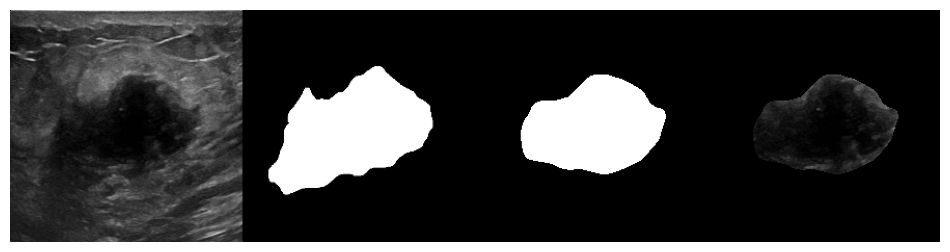

 Epoch: 56 of 100, Iter.: 16 of 16, Train Loss: 0.057930, IoU: 0.929216, Dice: 0.962821
 Epoch: 56 of 100, Iter.: 16 of 16, Valid Loss: 0.621736, IoU: 0.579815, Dice: 0.700002


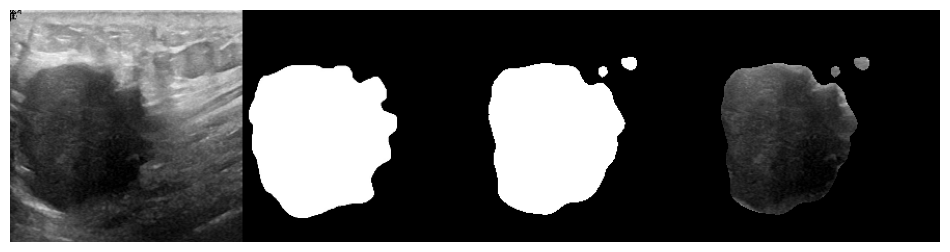

 Epoch: 57 of 100, Iter.: 16 of 16, Train Loss: 0.055952, IoU: 0.931289, Dice: 0.963856
 Epoch: 57 of 100, Iter.: 16 of 16, Valid Loss: 0.613029, IoU: 0.582716, Dice: 0.701664


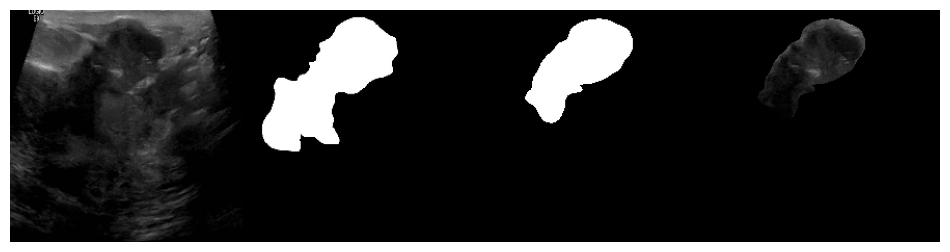

 Epoch: 58 of 100, Iter.: 16 of 16, Train Loss: 0.055408, IoU: 0.928159, Dice: 0.961174
 Epoch: 58 of 100, Iter.: 16 of 16, Valid Loss: 0.631993, IoU: 0.578360, Dice: 0.700822


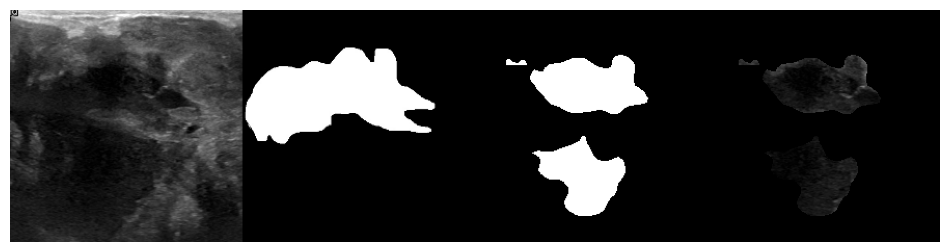

 Epoch: 59 of 100, Iter.: 16 of 16, Train Loss: 0.057082, IoU: 0.932284, Dice: 0.964657
 Epoch: 59 of 100, Iter.: 16 of 16, Valid Loss: 0.627275, IoU: 0.569476, Dice: 0.686161


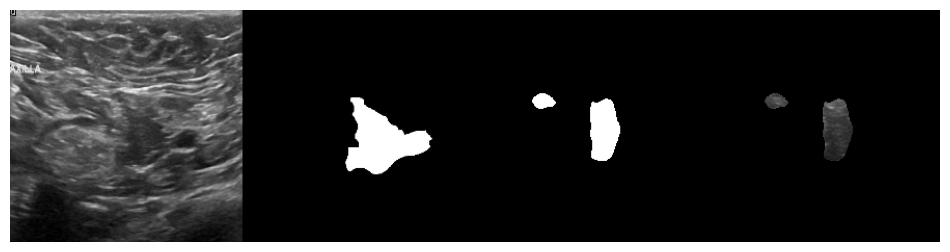


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 2min 58s, sys: 3min 6s, total: 6min 4s
Wall time: 2min 16s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:38, Best_IOU:0.5922, Best_DiceScore:0.7131


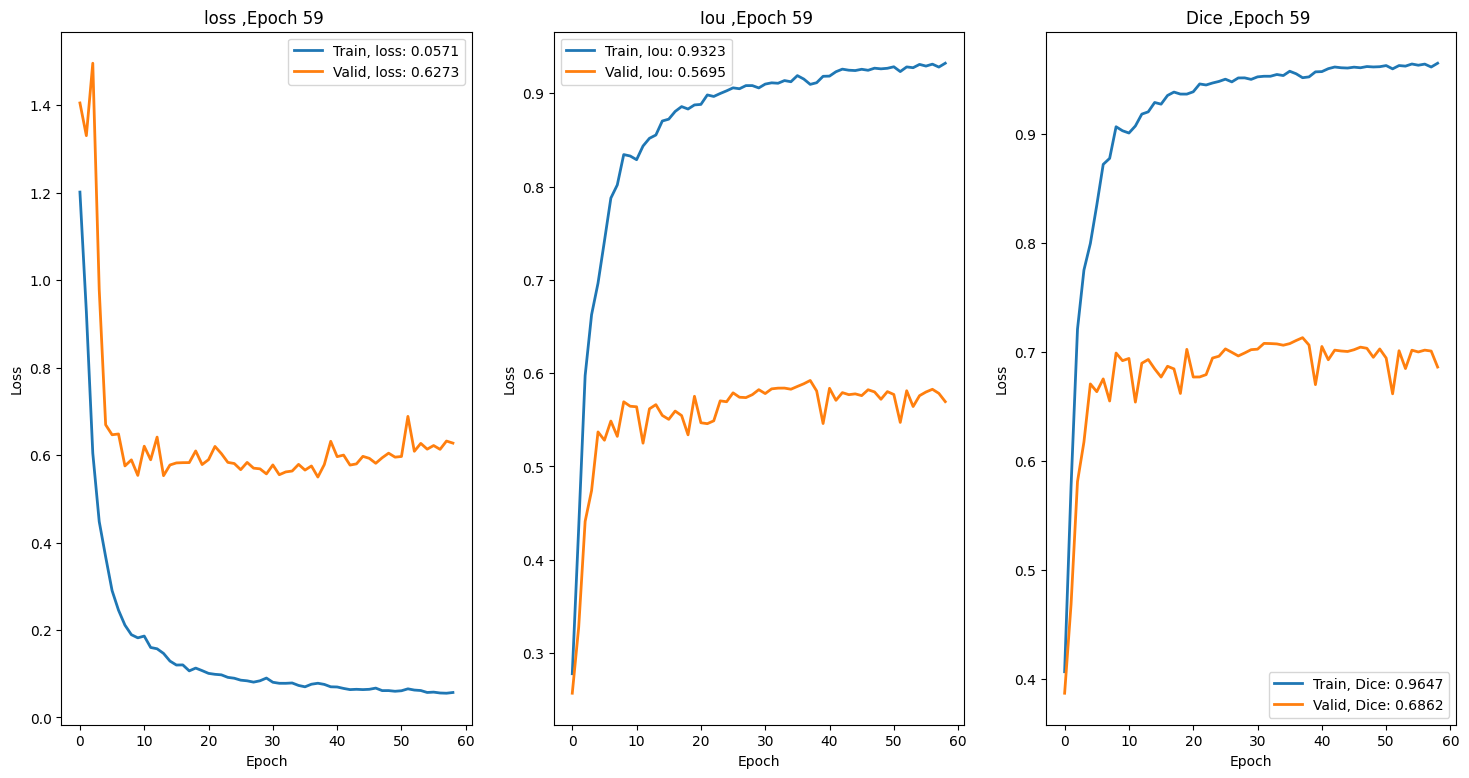

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()